In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import pickle

# I. Preparing the dataset

In [2]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    data_dir='~/aiffel/CV-Augmentation/tensorflow_datasets',
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes

## step1. Vanila data augmentation method

In [3]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)
    
    # 새로 수정한 내용
    alpha = 1
    lam = np.random.beta(alpha, alpha)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-lam), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-lam), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label


def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# 데이터셋에 augmentation 적용하는 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    # 위에서 만든 normalize 함수를 병렬로 map 하기
    ds = ds.map(
        normalize_and_resize_img,   # 기본적인 전처리 함수 적용
        num_parallel_calls=2        # 병렬처리할 때 가용할 CPU 코어 개수
    )
    # apply base augmentation
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    # split dataset into batches of batch_size    
    ds = ds.batch(batch_size)
    
    
    if not is_test and with_cutmix:      # apply CutMix augmentation
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:     # apply MixUP augmentation
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:                                # apply one-hot encoding
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

![](https://velog.velcdn.com/images/joonlaxy/post/cd4198a4-000f-477a-95b5-73bc1834fa17/image.png)

논문에서는 베타 분포 Beta(alpha, alpha)로 부터 combination ratio lamda가 추출되었다고 하여, 
Numpy의 beta distribution을 위한 `lam = np.random.beta(alpha, alpha)`를 추가하여 수식을 수정하였다.
이후 alpha를 `1`이 아닌 `1.5`등 숫자를 바꾸며 테스트해보았습니다.

### 1. creating no augmentation dataset

In [4]:
# No augmentation
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=False)
ds_test_no_aug = apply_normalize_on_dataset(ds_test, is_test=True)

### 2. creating vanila augmentation dataset

In [5]:
# 기본 Augmentation 적용한 데이터셋 생성
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
# ds_test_aug = apply_normalize_on_dataset(ds_test,  with_aug=True, is_test=True)

### 3. creating cutmix augmentation dataset

In [6]:
# CutMix Augmentation 적용한 데이터셋 생성
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_cutmix=True) 
# ds_test_cutmix_aug  = apply_normalize_on_dataset(ds_test,  with_cutmix=True, is_test=True)
'''
def _augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

ds = ds_train_cutmix_aug.map(_augment, num_parallel_calls=2)
new_ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
'''

'\ndef _augment(image,label):\n    image = tf.image.random_flip_left_right(image)\n    image = tf.image.random_brightness(image, max_delta=0.2)\n    image = tf.clip_by_value(image, 0, 1)\n    return image, label\n\nds = ds_train_cutmix_aug.map(_augment, num_parallel_calls=2)\nnew_ds = ds.prefetch(tf.data.experimental.AUTOTUNE)\n'

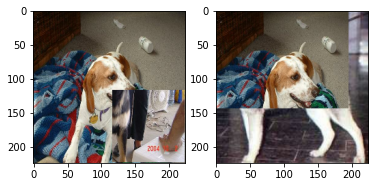

In [7]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_cutmix_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

### 4. creating mixup augmentation dataset

In [8]:
# MixUp Augmentation 적용한 데이터셋 생성
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train, with_mixup=True) 
# ds_test_mixup_aug  = apply_normalize_on_dataset(ds_test,  with_mixup=True, is_test=True)

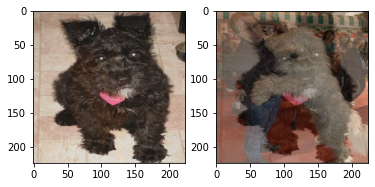

In [9]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_mixup_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

# II. Preparing the ResNet-50 model by keras

In [10]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

## 1) ResNet-50 for vanlia datasets(No Augmentation)

In [11]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    # stanford_dogs 데이터셋은 120종류의 다양한 견종이 존재함
    keras.layers.Dense(120, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


## 2) ResNet-50 for vanlia augmentation

In [12]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    # stanford_dogs 데이터셋은 120종류의 다양한 견종이 존재함
    keras.layers.Dense(120, activation='softmax')
])

## 3) ResNet-50 for Cutmix augmentation

In [13]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    # stanford_dogs 데이터셋은 120종류의 다양한 견종이 존재함
    keras.layers.Dense(120, activation='softmax')
])

## 4) ResNet-50 for Mixup augmentation

In [14]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    # stanford_dogs 데이터셋은 120종류의 다양한 견종이 존재함
    keras.layers.Dense(120, activation='softmax')
])

# III. Training the model

## Model training

In [15]:
# 하이퍼파라미터 설정
BATCH_SIZE = 16
EPOCH = 20  # Augmentation 적용 효과를 확인하기 위해 필요한 epoch 수


# 모델 저장 디렉토리
import os

SAVE_PATH = '~/aiffel/CV-Augmentation/'

### Resnet-50 training using No augmentation dataset

In [16]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:
if os.path.isfile('./resnet50_no_aug.h5'):
    history_resnet50_no_aug = pickle.load(open('./resnet50_no_aug.pkl', 'rb'))
    # keras.models.load_model('./resnet50_no_aug.h5')
else:
    history_resnet50_no_aug = resnet50.fit(
        ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=EPOCH,
        validation_data=ds_test_no_aug, #ds_test_no_aug
        verbose=1,
        use_multiprocessing=True,
    )
    resnet50.save('./resnet50_no_aug.h5')
    pickle.dump(history_resnet50_no_aug.history, open('./resnet50_no_aug.pkl', 'wb'))

### Resnet-50 training using vanila augmentation dataset

In [18]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [19]:
if os.path.isfile('./resnet50_vanila_aug.h5'):
    history_resnet50_aug = pickle.load(open('./resnet50_vanila_aug.pkl', 'rb'))
    # keras.models.load_model('./resnet50_vanila_aug.h5')
else:
    history_resnet50_aug = aug_resnet50.fit(
        ds_train_aug, # augmentation 적용한 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=EPOCH,
        validation_data=ds_test_no_aug, # ds_test_aug
        verbose=1,
        use_multiprocessing=True,
    )
    aug_resnet50.save('./resnet50_vanila_aug.h5')
    pickle.dump(history_resnet50_aug.history, open('./resnet50_vanila_aug.pkl', 'wb'))

### Resnet-50 training using cutmix augmentation dataset

In [20]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [21]:
if os.path.isfile('./resnet50_cutmix_aug.h5'):
    history_resnet50_cutmix_aug = pickle.load(open('./resnet50_cutmix_aug.pkl', 'rb'))
    # keras.models.load_model('./resnet50_cutmix_aug.h5')
else:
    history_resnet50_cutmix_aug = cutmix_resnet50.fit(
        ds_train_cutmix_aug, # Cutmix augmentation 적용한 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=EPOCH,
        validation_data=ds_test_no_aug, # ds_test_cutmix_aug
        verbose=1,
        use_multiprocessing=True,
    )
    cutmix_resnet50.save('./resnet50_cutmix_aug.h5')
    pickle.dump(history_resnet50_cutmix_aug.history, open('./resnet50_cutmix_aug.pkl', 'wb'))

### Resnet-50 training using Mixup augmentation dataset

In [22]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [23]:
if os.path.isfile('./resnet50_mixup_aug.h5'):
    history_resnet50_mixup_aug = pickle.load(open('./resnet50_mixup_aug.pkl', 'rb'))
    # keras.models.load_model('./resnet50_mixup_aug.h5')
else:
    history_resnet50_mixup_aug = mixup_resnet50.fit(
        ds_train_mixup_aug, # augmentation 적용하지 않은 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=EPOCH,
        validation_data=ds_test_no_aug, # ds_test_mixup_aug
        verbose=1,
        use_multiprocessing=True,
    )
    mixup_resnet50.save('./resnet50_mixup_aug.h5')
    pickle.dump(history_resnet50_mixup_aug.history, open('./resnet50_mixup_aug.pkl', 'wb'))

In [24]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_mixup_aug.take(1)):
    if i == 0:
        print(label[1])
        print(label[2])
        break

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.78123295 0.         0.         0.         0.
 0.21876705 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

# IV. Visualization

## 1) Comapring no-augmentation with vanlia-augmentation

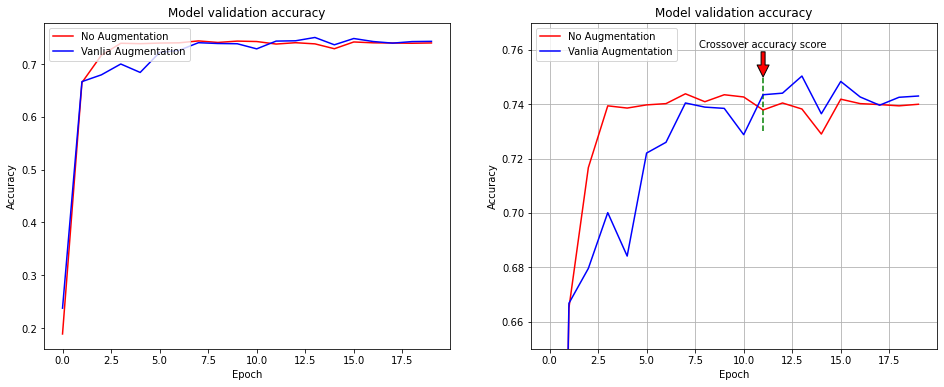

In [25]:
plt.figure(figsize=(16, 6))

# 훈련 과정을 시각화
plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r') # history_resnet50_no_aug.history['val_accuracy']
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Vanlia Augmentation'], loc='upper left')

# 조금 더 확대해 살펴봅시다.
plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Vanlia Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.65, 0.77)    # (0.72, 0.76) : 20 epoch
plt.vlines(11,0.73, 0.75,'g','--')
plt.annotate('Crossover accuracy score',
ha = 'center', va = 'bottom',
xytext = (11, 0.76),xy = (11, 0.75),arrowprops = {'facecolor' : 'red'})

plt.show()

우측 조금 더 확대된 그래프를 확인해보면  
11번째 epoch부터 기본적인 Augmentation을 적용한 경우 Accuracy가 적용하지 않은경우보다 미소하게 증가함을 확인할 수 있었다.

## 2) Comapring vanlia-augmentation with cutmix-augmentation

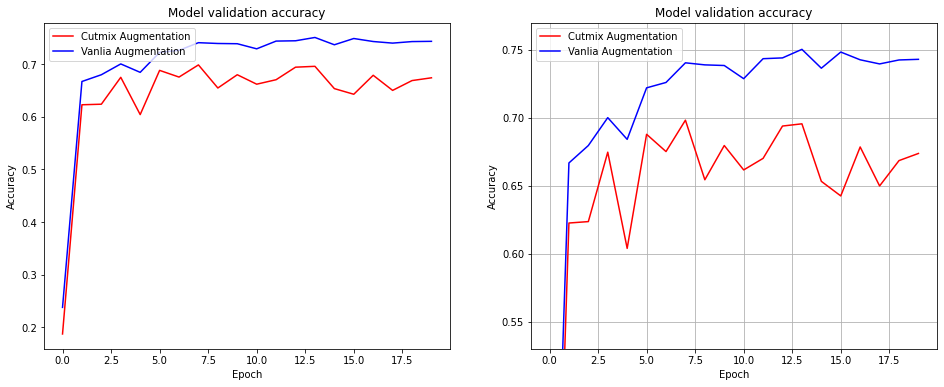

In [26]:
plt.figure(figsize=(16, 6))

# 훈련 과정을 시각화
plt.subplot(1, 2, 1)
plt.plot(history_resnet50_cutmix_aug['val_accuracy'], 'r') # history_resnet50_no_aug.history['val_accuracy']
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Cutmix Augmentation', 'Vanlia Augmentation'], loc='upper left')

# 조금 더 확대해 살펴봅시다.
plt.subplot(1, 2, 2)
plt.plot(history_resnet50_cutmix_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Cutmix Augmentation', 'Vanlia Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.53, 0.77)    # (0.72, 0.76) : 20 epoch

plt.show()

## 3) Comapring vanlia-augmentation with mixup-augmentation

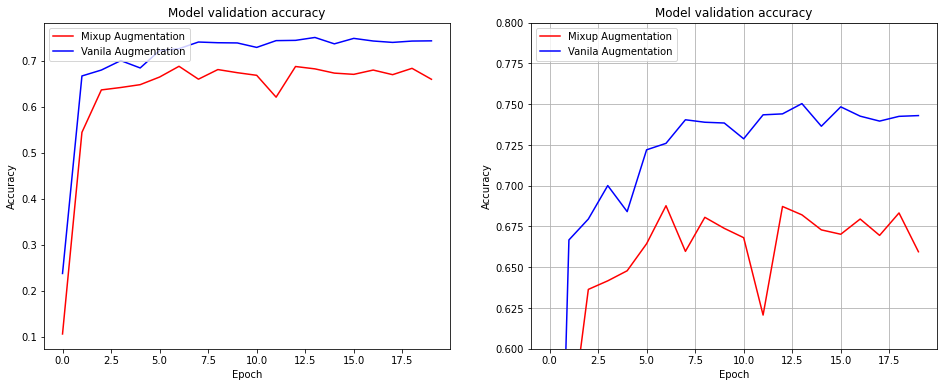

In [27]:
plt.figure(figsize=(16, 6))

# 훈련 과정을 시각화
plt.subplot(1, 2, 1)
plt.plot(history_resnet50_mixup_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Mixup Augmentation', 'Vanila Augmentation'], loc='upper left')

# 조금 더 확대해 살펴봅시다.
plt.subplot(1, 2, 2)
plt.plot(history_resnet50_mixup_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Mixup Augmentation', 'Vanila Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.80)    # (0.72, 0.76) : 20 epoch

plt.show()

## 4) Comparing whole validation accuracy history

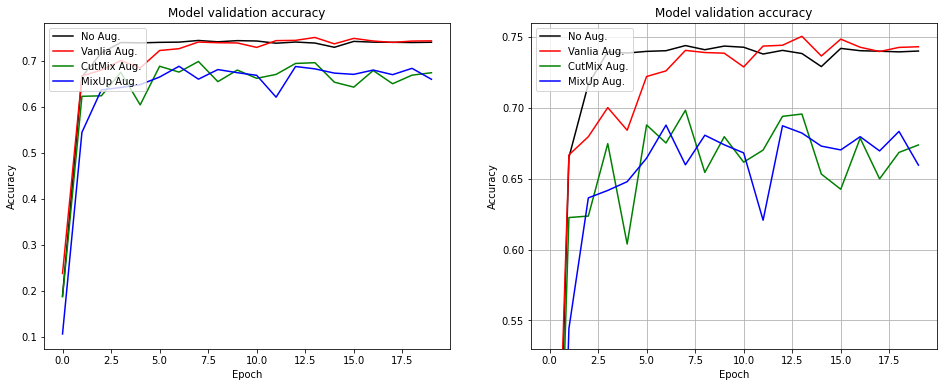

In [28]:
plt.figure(figsize=(16, 6))

# 훈련 과정을 시각화
plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug['val_accuracy'], 'k')
plt.plot(history_resnet50_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix_aug['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup_aug['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug.', 'Vanlia Aug.', 'CutMix Aug.', 'MixUp Aug.'], loc='upper left')

# 조금 더 확대해 살펴봅시다.
plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug['val_accuracy'], 'k')
plt.plot(history_resnet50_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix_aug['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup_aug['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug.', 'Vanlia Aug.', 'CutMix Aug.', 'MixUp Aug.'], loc='upper left')
plt.grid(True)
plt.ylim(0.53, 0.76)    # (0.72, 0.76) : 20 epoch

plt.show()

#### 실험 결과
- 기본적인 __Agumentaion__만 하였을때, 가장 높은 성능을 보여주는 아이러니한 상황이 발생하였다.


|valdiation accuracy|5epoch|10epoch|15epoch|20epoch|
|--|--|--|--|--|
|No Agumentation|0.7385|0.7434|0.7290|0.7399|
|__Vanila Agumentation__|0.6841|0.7385|__0.7365__|__0.7430__|
|Cutmix Agumentation|0.6039|0.6796|0.6532|0.6737|
|Mixup Agumentation|0.6479|0.6739|0.6729|0.6595|

|평가문항|상세기준|
|--|--|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|

# V. Try more

- `Cutmix`의 성능이 생각보다 낮게 나와 여러 내용을 찾아보고 시도해봤다.

```bash
1. 두 데이터를 일정 비율로 섞는 lamda와 연관된 하이퍼파라미터 alpha를 1에서 1.5로 소폭 증가시킴

2. Cutmix진행 후, rotate, flip등 2차 Agumentation 진행  
```

In [30]:
cutmix_alpha_1 = pickle.load(open('./resnet50_cutmix_aug.pkl', 'rb'))
cutmix_alpha_1_dot_5 = pickle.load(open('./resnet50_cutmix_aug_a1.5.pkl', 'rb'))
cutmix_alpha_1_with_aug = pickle.load(open('./resnet50_cutmix_aug_more.pkl', 'rb'))

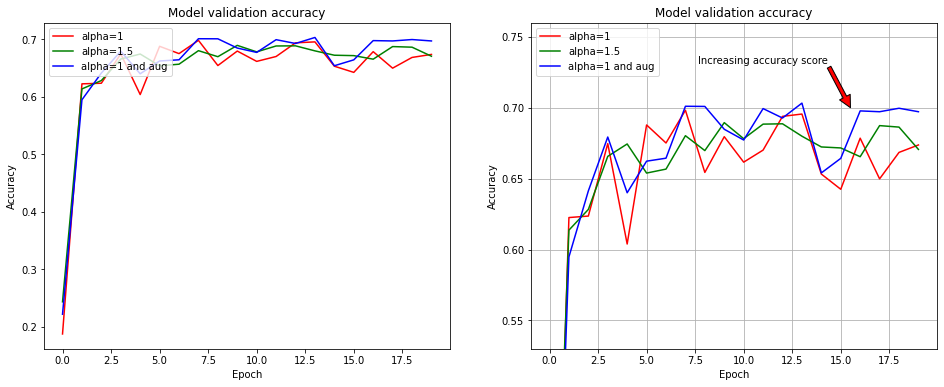

In [31]:
plt.figure(figsize=(16, 6))

# 훈련 과정을 시각화
plt.subplot(1, 2, 1)
plt.plot(cutmix_alpha_1['val_accuracy'], 'r')
plt.plot(cutmix_alpha_1_dot_5['val_accuracy'], 'g')
plt.plot(cutmix_alpha_1_with_aug['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['alpha=1', 'alpha=1.5', 'alpha=1 and aug'], loc='upper left')

# 조금 더 확대해 살펴봅시다.
plt.subplot(1, 2, 2)
plt.plot(cutmix_alpha_1['val_accuracy'], 'r')
plt.plot(cutmix_alpha_1_dot_5['val_accuracy'], 'g')
plt.plot(cutmix_alpha_1_with_aug['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['alpha=1', 'alpha=1.5', 'alpha=1 and aug'], loc='upper left')
plt.grid(True)
plt.ylim(0.53, 0.76)    # (0.72, 0.76) : 20 epoch
plt.annotate('Increasing accuracy score',
ha = 'center', va = 'bottom',
xytext = (11, 0.73),xy = (15.5, 0.7),arrowprops = {'facecolor' : 'red'})

plt.show()

### cutmix의 하이퍼 파라미터를 변경한 경우와 추가적으로 `flip`과 `brightness`를 더 한 경우의 성능 비교
|valdiation accuracy|16epoch|17epoch|18epoch|19epoch|20epoch|
|--|--|--|--|--|--|
|alpha = 1|0.6425|0.6785|0.6498|0.6685|0.6737|
|alpha = 1.5|0.6716|0.6655|0.6874|0.6863|0.6706|
|__alpha = 1 and aug__|0.6643|0.6978|0.6972|0.6996|__0.6972__|

- 논문처럼 `alpha=1` 인 상황에서 추가적인 Augmentation을 실시하였을 뿐인데 성능이 __소폭 상승함__을 알 수 있었다. 
- 만약 충분한 학습 시간이 있다면 더 좋은 성능을 보이지 않을까 싶은 __가능성이 보인다.__

In [ ]:
_ = []
for i, v in enumerate(cutmix_alpha_1_with_aug['val_accuracy']):
    if (i+1)%5==0:
        _.append(f'{v:.4f}')
print(f'|{_[0]}|{_[1]}|{_[2]}|{_[3]}|')


In [ ]:
_ = []
for i, v in enumerate(cutmix_alpha_1['val_accuracy']):
    _.append(f'{v:.4f}')
print(f'|{_[15]}|{_[16]}|{_[17]}|{_[18]}|{_[19]}|')